In [1]:
# Library Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import umap
import hdbscan
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from matplotlib.lines import Line2D

In [2]:
df = pd.read_json(os.path.join(
    'script_outputs',
    'role_playing_misinformation_labelling_output',
    'role_playing_label_outputs.json'
))

for _, row in df.groupby('round'):
    print(len(row))

2034
4068
4068


In [ ]:
for item in df[(df['url'] == 'https://www.politifact.com/factchecks/2024/oct/14/facebook-posts/photos-of-disney-world-destroyed-by-hurricane-milt/') & (df['round'] == 2)].iloc():
    for i in item['previous_claims']:
        print(f"Round {i['round']} / {i['role']}: {i['Claim']}")
    print(f"Round {item['generated_claims']['round']} / {item['generated_claims']['role']}: {item['generated_claims']['Claim']}")

Round 0:  Facts over fiction: Don't fall for satirical 'Breaking News' - Disney World was NOT destroyed by Hurricane Milton, despite fake photos.
Round 1:  Facts matter: Don't fall for satirical 'Breaking News' - Disney World was NOT destroyed by Hurricane Milton, a fake storm.
Round 2: Be cautious of misinformation: Disney World's damage photos were taken from a satirical article, not a real news report.
Round 0:  Facts over fiction: Don't fall for satirical 'Breaking News' - Disney World was NOT destroyed by Hurricane Milton, despite fake photos.
Round 1:  Be cautious of satirical 'Breaking News' - Photos of Disney World 'destroyed' by Hurricane Milton are fake, a Mouse Trap News joke.
Round 2: Fake news is a threat to American values: Satirical 'Breaking News' spreads lies, undermines trust in our institutions, and harms our nation.
Round 0:  Folks, be cautious of fake news: Photos from satirical Mouse Trap News website claim Disney World 'destroyed by Hurricane Milton' - a clear ca

## Results & Visualizations

In this section, we will be showing our metrics, GPT-4o-mini Evaluation, Classification Metrics and Claim Analysis.

### Generated Claim Analysis

To assess the characteristics of each generated claim, we apply the following automated metrics:

    Readability: Flesch-Kincaid Grade Level (FKGL)

    Perplexity: Approximated using a pre-trained GPT-2 model

    Sentiment: Detected via HuggingFace's Sentiment Analysis Pipeline.

    Moral Foundations: Classified using MoralBERT (care, harm, fairness, etc.)

In [3]:
%%capture
# === Load Data ===
df = pd.read_json(os.path.join(
    'script_outputs',
    'role_playing_misinformation_labelling_output',
    'role_playing_label_outputs.json'
))

# === Readability ===
def compute_readability(text):
    return textstat.flesch_kincaid_grade(text)

# === Perplexity ===
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_model.eval()

def compute_perplexity(text):
    encodings = gpt2_tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    input_ids = encodings.input_ids
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
    loss = outputs.loss
    return torch.exp(loss).item()

# === Sentiment ===
# sentiment_analyzer = pipeline("sentiment-analysis")
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device='cuda')


def get_sentiment(text):
    return sentiment_analyzer(text)[0]  # {'label': 'POSITIVE', 'score': 0.99}

# === Enrich DataFrame ===
def enrich_dataframe(df):
    original_details = []
    # Fill up original details
    for _, row in df.iterrows():
        current_data = {
            'url': row['url'],
            'role': 'Original',
            'role_sequence': 'Original',
            'round': -1,
            'claim_text': row['claim'],
            'explanation': None
        }
        if current_data not in original_details:
            original_details.append(current_data)
    # Fill up the remaining data
    for _, row in df.iterrows():
        current_data = {
            'url': row['url'],
            'role': row['role'],
            'role_sequence': row['role_sequence'],
            'round': row['round'],
            'claim_text': row['generated_claims']['Claim'],
            'explanation': row['generated_claims']['Explanation']
        }
        original_details.append(current_data)

    new_df = pd.DataFrame(original_details)

    print("Running readability...")
    new_df['readability'] = new_df['claim_text'].apply(compute_readability)

    print("Running perplexity (may take a while)...")
    new_df['perplexity'] = new_df['claim_text'].apply(compute_perplexity)

    print("Running sentiment analysis...")
    sentiments = new_df['claim_text'].apply(get_sentiment)
    new_df['sentiment_label'] = [row['label'] for row in sentiments]
    new_df['sentiment_score'] = [row['score'] for row in sentiments]

    return new_df

# === Run Everything ===
df_enriched = enrich_dataframe(df)

# === Save or Preview ===
df_enriched.to_csv("enriched_claims_analysis.csv", index=False)
print(df_enriched[['claim_text', 'readability', 'perplexity', 'sentiment_label', 'sentiment_score']].head())


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [4]:
%%capture
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = preprocessing(texts, tokenizer)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

class MyModel(
    nn.Module,
    PyTorchModelHubMixin,
    # optionally, you can add metadata which gets pushed to the model card
    # repo_url="your-repo-url",
    pipeline_tag="text-classification",
    license="mit",
):
    def __init__(self, bert_model, moral_label=2):

        super(MyModel, self).__init__()
        self.bert = bert_model
        bert_dim = 768
        self.invariant_trans = nn.Linear(768, 768)
        self.moral_classification = nn.Sequential(nn.Linear(768,768),
                                                      nn.ReLU(),
                                                      nn.Linear(768, moral_label))

    def forward(self, input_ids, token_type_ids, attention_mask):
        pooled_output = self.bert(input_ids,
                                token_type_ids = token_type_ids,
                                attention_mask = attention_mask).last_hidden_state[:,0,:]


        pooled_output = self.invariant_trans(pooled_output)


        logits = self.moral_classification(pooled_output)

        return logits


def preprocessing(input_text, tokenizer):
    '''
    Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
    '''
    return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 150,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_token_type_ids = True,  # Add this line
                        return_tensors = 'pt',
                        truncation=True
                   )

# === Load Data ===
df = pd.read_json(os.path.join(
    'script_outputs',
    'role_playing_misinformation_labelling_output',
    'role_playing_label_outputs.json'
))

# === MFT Setup ===
mft_values = ["care", "harm", "fairness", "cheating", "loyalty", "betrayal",
              "authority", "subversion", "purity", "degradation"]

# === Batch settings ===
BATCH_SIZE = 8

# === Model + Tokenizer cache ===
models = {}
tokenizers = {}

for mft in mft_values:
    repo_name = f"vjosap/moralBERT-predict-{mft}-in-text"
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = MyModel.from_pretrained(repo_name, bert_model=AutoModel.from_pretrained("bert-base-uncased"))
    model.eval()
    tokenizers[mft] = tokenizer
    models[mft] = model.to('cuda') 

# === Initialize results with metadata ===
results = []
for _, row in df.iterrows():
    current_data = {
        'url': row['url'],
        'role': 'Original',
        'role_sequence': 'Original',
        'round': -1,
        'sentence': row['claim']
    }
    if current_data not in results:
        results.append(current_data)

for _, row in df.iterrows():
    data = {
        "sentence": row['generated_claims']['Claim'],
        "url": row['url'],
        "round": row['round'],
        "role": row['role'],
        "role_sequence": row['role_sequence']
    }
    results.append(data)


# === Collect all sentences ===
sentences = [item['sentence'] for item in results]
print(len(sentences))

# === Scoring ===
for mft in mft_values:
    tokenizer = tokenizers[mft]
    model = models[mft]

    all_scores = []

    # Process in batches
    for i in tqdm(range(0, len(sentences), BATCH_SIZE), desc=f"Processing MFTs: {mft}"):
        batch = sentences[i:i+BATCH_SIZE]
        encodings = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        encodings = encodings.to('cuda')
        with torch.no_grad():
            output = model(**encodings)
            probs = F.softmax(output, dim=1)
            mft_scores = probs[:, 1].tolist()  # Get score for class 1

        all_scores.extend(mft_scores)

    # Add scores to result dicts
    for j in range(len(results)):
        results[j][mft] = all_scores[j]

# === Convert to DataFrame ===
results_df = pd.DataFrame(results)
print(results_df.head())

# === Save ===
results_df.to_csv("moral_foundation_scores.csv", index=False)


Readability Results

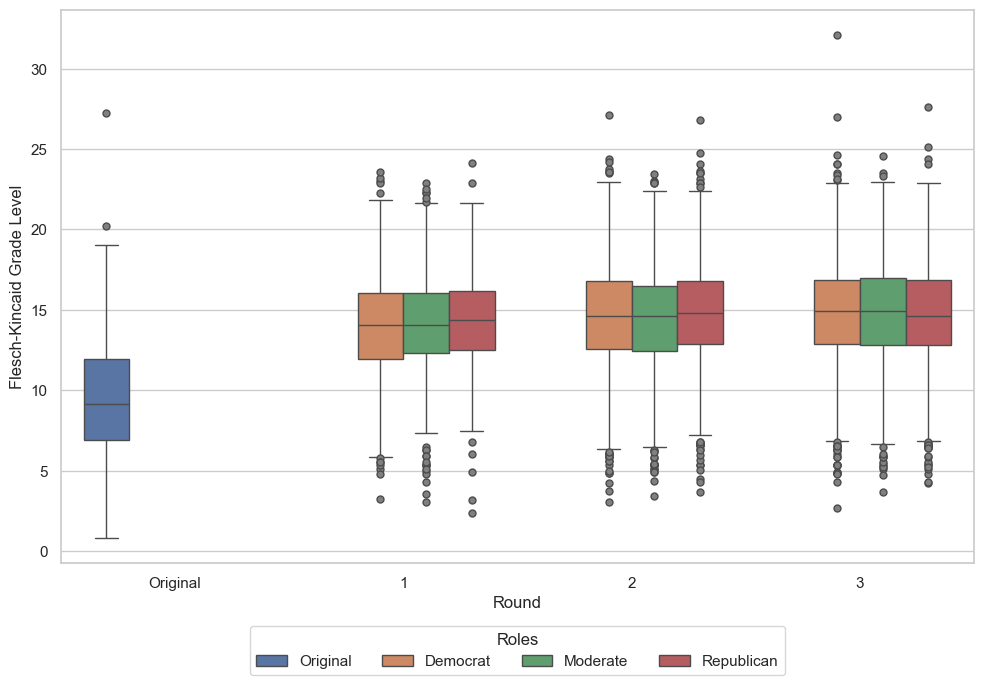

                        median         q1         q3       IQR
round    role                                                 
1        Democrat    14.040000  11.962222  16.053636  4.091414
         Moderate    14.065385  12.314737  16.041053  3.726316
         Republican  14.374444  12.479412  16.200000  3.720588
2        Democrat    14.630000  12.568000  16.761905  4.193905
         Moderate    14.596389  12.441944  16.462500  4.020556
         Republican  14.808224  12.860000  16.761905  3.901905
3        Democrat    14.928000  12.860000  16.878333  4.018333
         Moderate    14.927826  12.835455  16.990000  4.154545
         Republican  14.640000  12.828571  16.878333  4.049762
Original Original     9.140000   6.919764  11.948750  5.028986


In [5]:
# === Load Data ===
df = pd.read_csv('enriched_claims_analysis.csv')
df['round'] = df['round'].apply(lambda x: 'Original' if x == -1 else str(x + 1))

# === Set up plot ===
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Draw boxplot
box_plot = sns.boxplot(data=df, x='round', y='readability', hue='role', flierprops={
        'marker': 'o',
        'markerfacecolor': 'grey',  # filled solid
        'markersize': 5,
        'linestyle': 'none'
    })

# Get sorted rounds and roles
rounds = sorted(df['round'].unique())
roles = sorted(df['role'].unique())
role_count = len(roles)

# === Final touches ===
plt.xlabel("Round")
plt.ylabel("Flesch-Kincaid Grade Level")
plt.legend(title="Roles", ncol=4, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.tight_layout()
plt.show()

grouped = df.groupby(['round', 'role'])['readability']
stats = grouped.agg(
    median='median',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75)
)
stats['IQR'] = stats['q3'] - stats['q1']
print(stats)

Perplexity Results

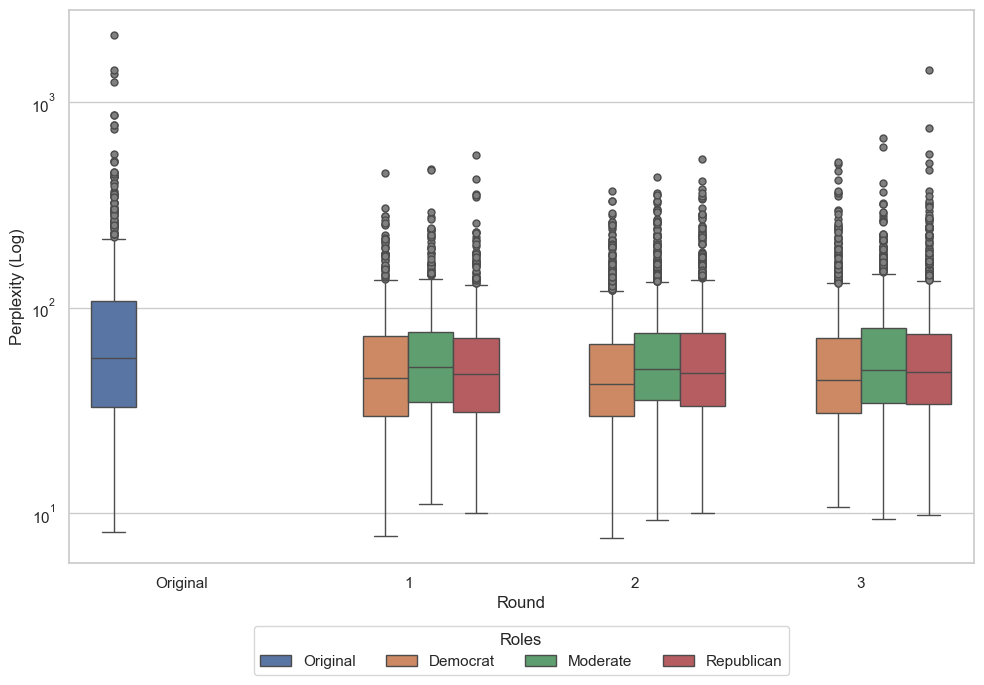

                        median         q1          q3        IQR
round    role                                                   
1        Democrat    45.333971  29.867857   72.564137  42.696279
         Moderate    51.480309  34.830638   76.179413  41.348775
         Republican  47.523003  30.997554   71.064013  40.066459
2        Democrat    42.397257  29.689071   66.289585  36.600514
         Moderate    50.157854  35.502566   74.921556  39.418990
         Republican  48.115370  33.383025   75.320181  41.937156
3        Democrat    44.668144  30.900360   71.036570  40.136209
         Moderate    49.817209  34.516409   79.258442  44.742033
         Republican  48.755896  33.839017   74.667191  40.828174
Original Original    56.970041  32.777806  107.232412  74.454606


In [6]:
# === Load Data ===
df = pd.read_csv('enriched_claims_analysis.csv')
df['round'] = df['round'].apply(lambda x: 'Original' if x == -1 else str(x + 1))

# === Set up plot ===
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Draw boxplot
box_plot = sns.boxplot(data=df, x='round', y='perplexity', hue='role', flierprops={
        'marker': 'o',
        'markerfacecolor': 'grey',  # filled solid
        'markersize': 5,
        'linestyle': 'none'
    })

# Get sorted rounds and roles
rounds = sorted(df['round'].unique())
roles = sorted(df['role'].unique())
role_count = len(roles)

# === Final touches ===
plt.xlabel("Round")
plt.ylabel("Perplexity (Log)")
plt.legend(title="Roles", ncol=4, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.yscale('log')
plt.tight_layout()
plt.show()

grouped = df.groupby(['round', 'role'])['perplexity']
stats = grouped.agg(
    median='median',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75)
)
stats['IQR'] = stats['q3'] - stats['q1']
print(stats)


Sentiment Analysis Results

C:\Users\60126\AppData\Local\Temp\ipykernel_34668\4265688671.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['round', 'role', 'sentiment_label']).size().reset_index(name='count')


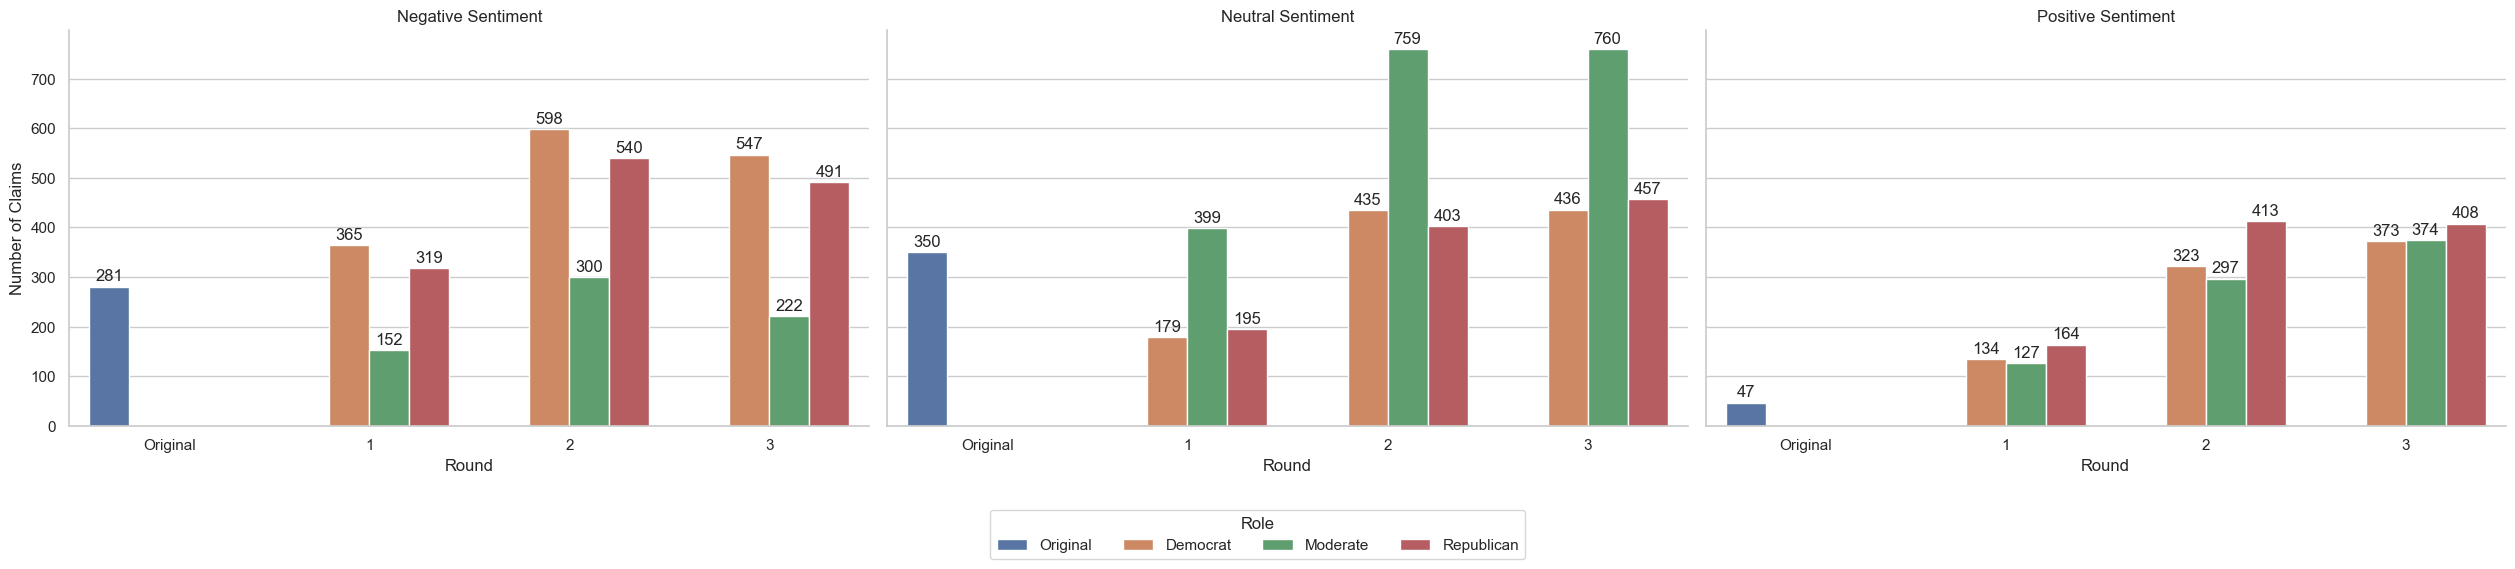

In [7]:
# === Load Data ===
df = pd.read_csv('enriched_claims_analysis.csv')

# Convert round: -1 becomes "Original", rest become "1", "2", ...
df['round'] = df['round'].apply(lambda x: 'Original' if x == -1 else str(x + 1))

labels = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive',
}

# Optional: round ordering
round_order = ['Original', '1', '2', '3']
df['round'] = pd.Categorical(df['round'], categories=round_order, ordered=True)
df['sentiment_label'] = df['sentiment_label'].apply(lambda x: labels[x])

# === Aggregate sentiment counts by (round, role, sentiment)
grouped = df.groupby(['round', 'role', 'sentiment_label']).size().reset_index(name='count')

# === Define role order explicitly for consistent coloring
role_order = ['Original', 'Democrat', 'Moderate', 'Republican']

# === Plot grouped barplot (faceted by sentiment label)
sns.set(style="whitegrid")
g = sns.catplot(
    data=grouped,
    x='round',
    y='count',
    hue='role',
    hue_order=role_order,
    col='sentiment_label',
    kind='bar',
    height=5,
    aspect=1.6,
)

# === Clean titles and labels
g.set_titles("")
g.set_axis_labels("Round", "Number of Claims")
g._legend.set_title("Role")
g._legend.remove()
g.fig.legend(
    title="Role",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4
)
g.set_titles(col_template="{col_name} Sentiment")



# === Annotate counts on top of bars
for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 5,
                    f"{int(height)}",
                    ha='center',
                    va='bottom',
                    fontsize=12
                )

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv('enriched_claims_analysis.csv')

# Convert round: -1 becomes "Original", rest become "1", "2", ...
df['round'] = df['round'].apply(lambda x: 'Original' if x == -1 else str(x + 1))

# Round ordering for consistent x-axis
round_order = ['Original', '1', '2', '3']
df['round'] = pd.Categorical(df['round'], categories=round_order, ordered=True)

# Define role order for consistent coloring
role_order = ['Original', 'Democrat', 'Moderate', 'Republican']

# === Group sentiment counts ===
grouped = df.groupby(['round', 'role', 'sentiment_label', 'sentiment_score']).size().reset_index(name='count')

grouped


C:\Users\60126\AppData\Local\Temp\ipykernel_34668\2765135700.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['round', 'role', 'sentiment_label', 'sentiment_score']).size().reset_index(name='count')


,round,role,sentiment_label,sentiment_score,count
0,Original,Democrat,LABEL_0,0.417931,0
1,Original,Democrat,LABEL_0,0.421179,0
2,Original,Democrat,LABEL_0,0.422421,0
3,Original,Democrat,LABEL_0,0.428651,0
4,Original,Democrat,LABEL_0,0.433476,0
...,...,...,...,...,...
518491,3,Republican,LABEL_2,0.975911,0
518492,3,Republican,LABEL_2,0.976827,0
518493,3,Republican,LABEL_2,0.977229,0
518494,3,Republican,LABEL_2,0.985286,0


Morality Results

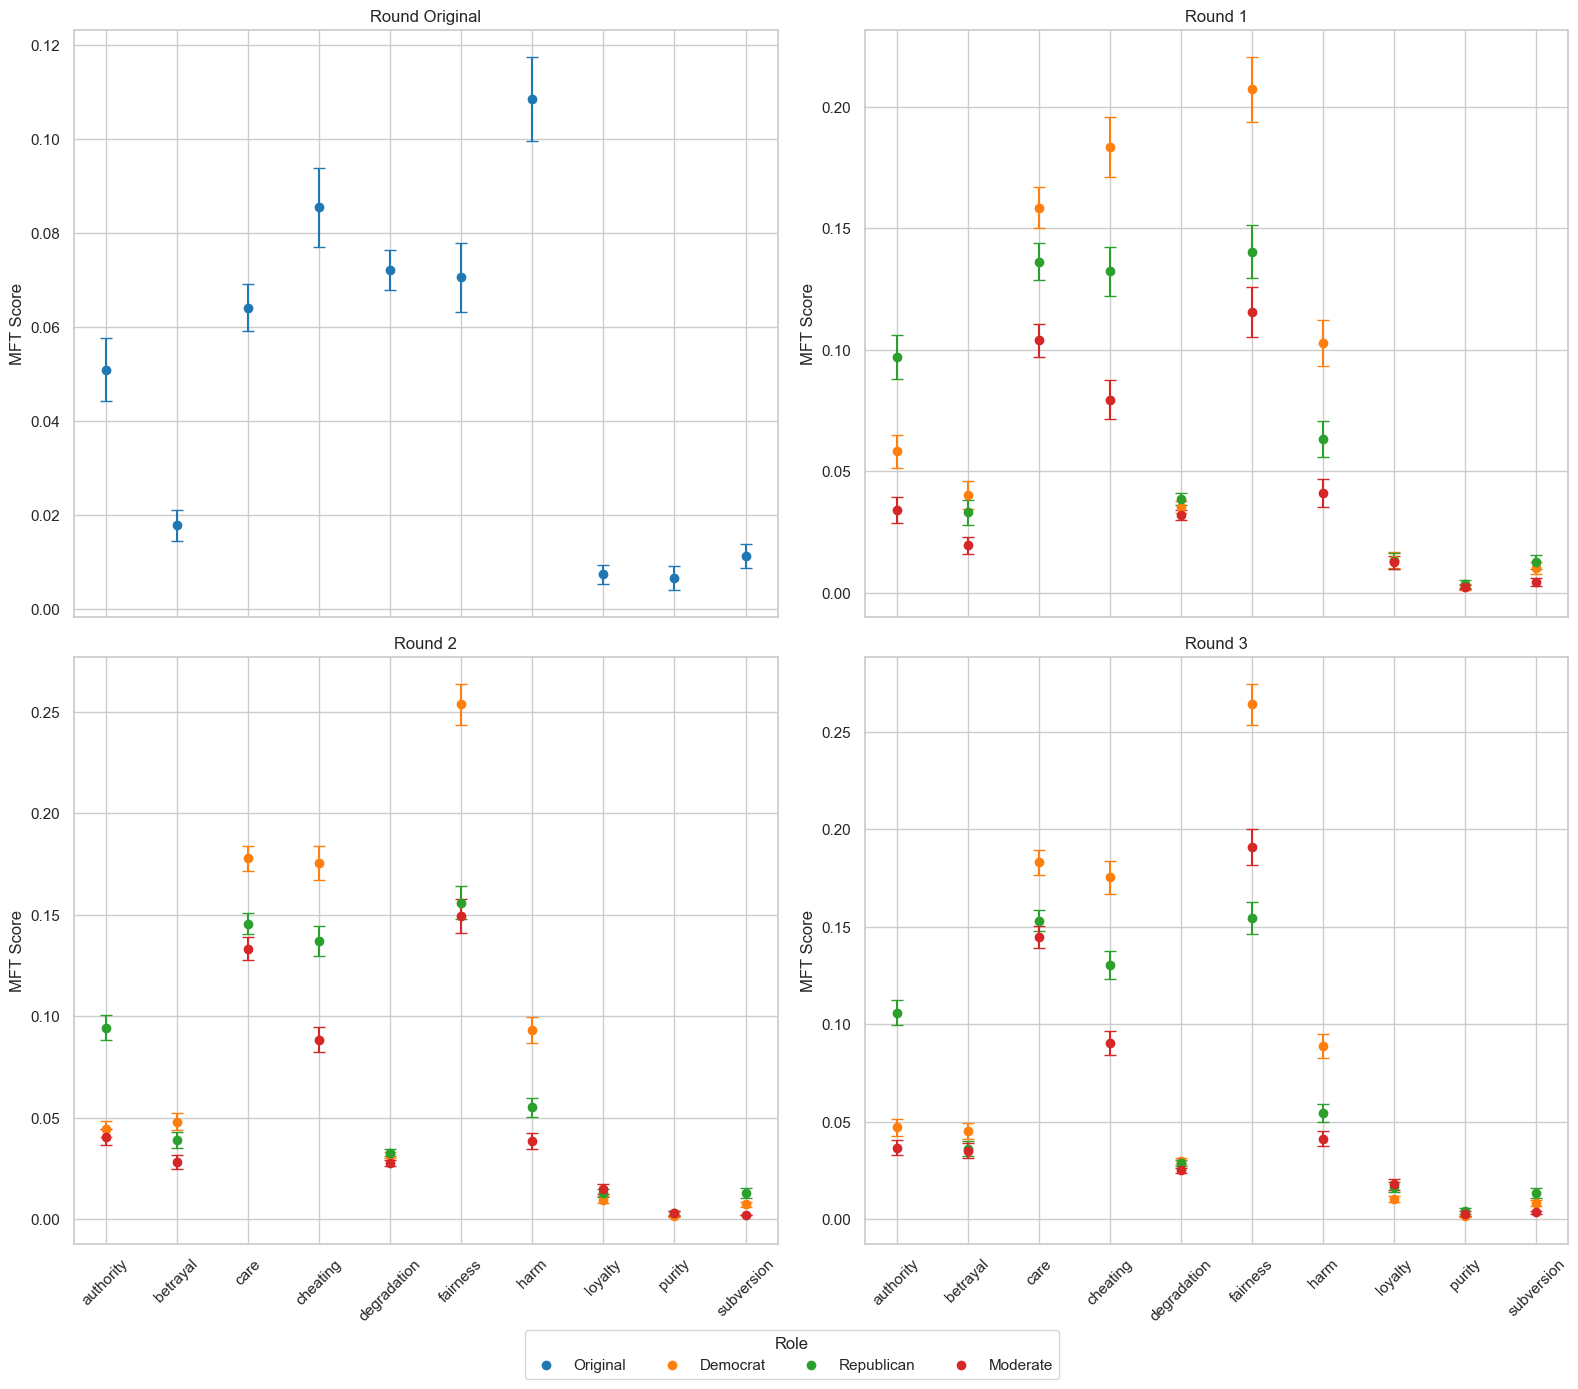

In [9]:
# === Load Data ===
df = pd.read_csv('moral_foundation_scores.csv')

# Convert round to label
df['round'] = df['round'].apply(lambda x: 'Original' if x == -1 else str(x + 1))

# Filter relevant roles
roles = ['Original', 'Democrat', 'Republican', 'Moderate']
df = df[df['role'].isin(roles)]

# Moral foundation columns
mft_columns = [
    "care", "harm", "fairness", "cheating", "loyalty", "betrayal",
    "authority", "subversion", "purity", "degradation"
]

# Melt to long format
melted = df.melt(
    id_vars=['round', 'role'],
    value_vars=mft_columns,
    var_name='mft',
    value_name='score'
)

# Compute mean + standard error
summary = (
    melted.groupby(['round', 'role', 'mft'])['score']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'score', 'sem': 'se'})
)

# Define rounds in order
rounds = ['Original', '1', '2', '3']
summary = summary[summary['round'].isin(rounds)]

# === Set role colors (fixed across subplots)
palette = sns.color_palette("tab10", n_colors=len(roles))
role_color_map = dict(zip(roles, palette))

# === Plot setup ===
fig, axes = plt.subplots(2, 2, figsize=(16, 15))
axes = axes.flatten()
sns.set(style="whitegrid")

# === One subplot per round ===
for i, round_label in enumerate(rounds):
    ax = axes[i]
    round_data = summary[summary['round'] == round_label]

    for role in roles:
        role_data = round_data[round_data['role'] == role]
        if not role_data.empty:
            ax.errorbar(
                role_data['mft'],
                role_data['score'],
                yerr=role_data['se'],
                fmt='o',
                capsize=4,
                label=role,  # only used once for global legend
                color=role_color_map[role]
            )

    ax.set_title(f"Round {round_label}")
    ax.set_ylabel("MFT Score")
    ax.tick_params(axis='x', rotation=45)

    if i in [0, 1]:  # remove x-axis label from top row
        ax.set_xlabel("")
        ax.set_xticklabels([])

# === Global Legend ===
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=role, markerfacecolor=color, markersize=8)
           for role, color in role_color_map.items()]

fig.legend(handles, roles, title="Role", loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=4)

# === Final layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
# plt.suptitle("Moral Foundation Scores by Round and Role", fontsize=16)
plt.show()


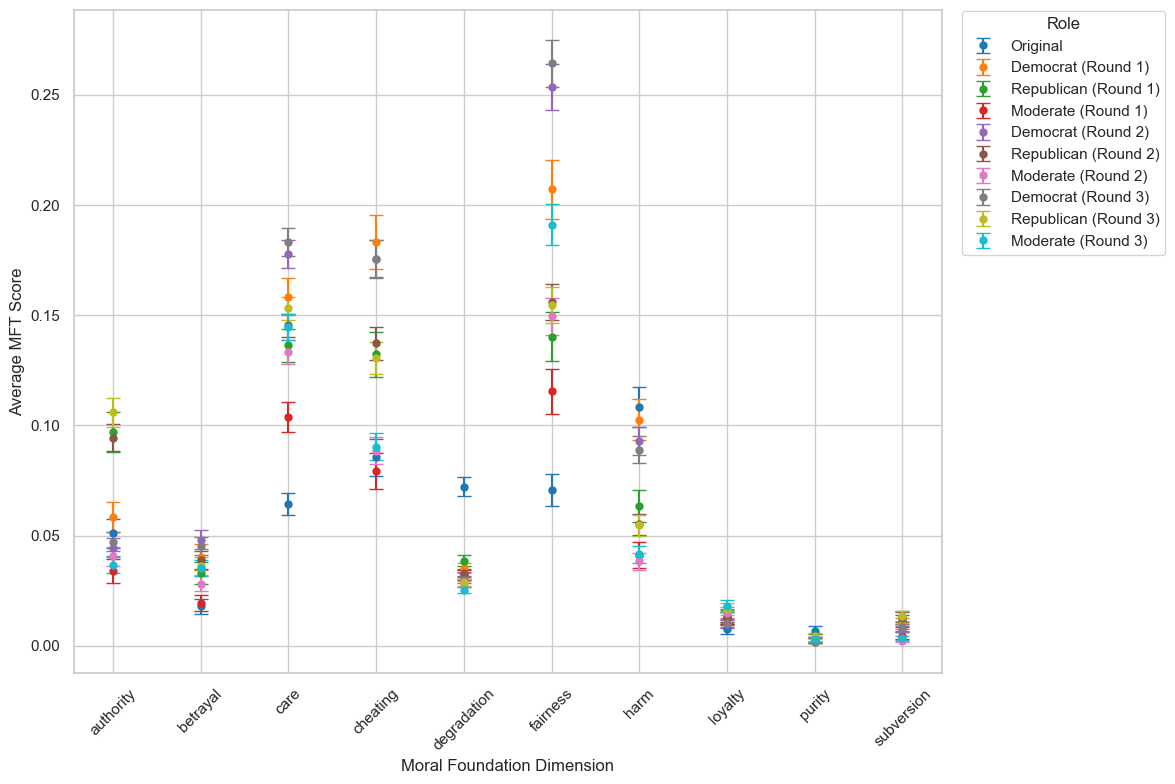

In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load and preprocess data ===
df = pd.read_csv('moral_foundation_scores.csv')

# Create new column combining role and round
df['role_round'] = df.apply(
    lambda row: 'Original' if row['round'] == -1 else f"{row['role']} (Round {row['round'] + 1})",
    axis=1
)

# Define final plotting labels
roles = [
    'Original',
    'Democrat (Round 1)', 'Republican (Round 1)', 'Moderate (Round 1)',
    'Democrat (Round 2)', 'Republican (Round 2)', 'Moderate (Round 2)',
    'Democrat (Round 3)', 'Republican (Round 3)', 'Moderate (Round 3)'
]

mft_columns = [
    "care", "harm", "fairness", "cheating", "loyalty", "betrayal",
    "authority", "subversion", "purity", "degradation"
]

# Reshape to long format
melted = df[df['role_round'].isin(roles)].melt(
    id_vars=['role_round'],
    value_vars=mft_columns,
    var_name='mft',
    value_name='score'
)

# Summary statistics
summary = (
    melted.groupby(['role_round', 'mft'])['score']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'score', 'sem': 'se'})
)

# === Plot setup ===
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Assign consistent colors
palette = sns.color_palette("tab10", n_colors=len(roles))
role_color_map = dict(zip(roles, palette))

# Plot each role-round's moral scores
for role in roles:
    data = summary[summary['role_round'] == role]
    plt.errorbar(
        data['mft'],
        data['score'],
        yerr=data['se'],
        fmt='o',
        label=role,
        capsize=5,
        markersize=5,
        color=role_color_map[role]
    )

plt.xlabel("Moral Foundation Dimension")
plt.ylabel("Average MFT Score")
plt.xticks(rotation=45)
plt.legend(title="Role", loc='upper center', bbox_to_anchor=(1.14, 1.01))
plt.tight_layout()
plt.show()



In [11]:
# Show all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Compute average score
avg_score = summary.groupby(['role_round', 'mft'])['score'].mean().reset_index()
avg_score = avg_score.rename(columns={'score': 'average_mft_score'})

# Compute average standard error
avg_se = summary.groupby(['role_round', 'mft'])['se'].mean().reset_index()
avg_se = avg_se.rename(columns={'se': 'average_mft_se'})

# Merge both on 'role_round' and 'mft'
average_scores_combined = pd.merge(avg_score, avg_se, on=['role_round', 'mft'])

# For each MFT dimension, find the row with the highest average score
highest_per_mft = average_scores_combined.loc[
    average_scores_combined.groupby('mft')['average_mft_score'].idxmax()
].reset_index(drop=True)

print(highest_per_mft)

             role_round          mft  average_mft_score  average_mft_se
0  Republican (Round 3)    authority           0.106054        0.006586
1    Democrat (Round 2)     betrayal           0.048193        0.004423
2    Democrat (Round 3)         care           0.183154        0.006345
3    Democrat (Round 1)     cheating           0.183363        0.012283
4              Original  degradation           0.072112        0.004253
5    Democrat (Round 3)     fairness           0.264265        0.010561
6              Original         harm           0.108502        0.009015
7    Moderate (Round 3)      loyalty           0.017946        0.002635
8              Original       purity           0.006631        0.002538
9  Republican (Round 3)   subversion           0.013497        0.002374


Clustering Results

d:\Anaconda\envs\cs5242\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

d:\Anaconda\envs\cs5242\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


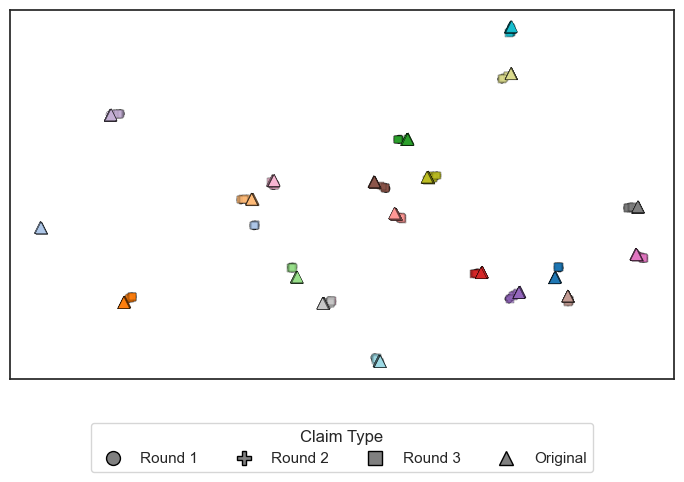

In [16]:
# === Load Data ===
df_raw = pd.read_json(os.path.join(
    'script_outputs',
    'role_playing_misinformation_labelling_output',
    'role_playing_label_outputs.json'
))

# Sample 20 URLs
urls = df_raw["url"].drop_duplicates().sample(20, random_state=42)
df_raw = df_raw[df_raw['url'].isin(urls)]

# === Flatten original + generated
results = []
for _, row in df_raw.iterrows():
    results.append({
        'url': row['url'],
        'role': 'Original',
        'role_sequence': 'Original',
        'round': -1,
        'sentence': row['claim'],
        'explanation': None
    })

for _, row in df_raw.iterrows():
    results.append({
        "sentence": row['generated_claims']['Claim'],
        "url": row['url'],
        "round": row['round'],
        "role": row['role'],
        "role_sequence": row['role_sequence'],
        'explanation': row['generated_claims']['Explanation'],
    })

df = pd.DataFrame(results)

# === SBERT Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2').to('cuda')
embeddings = model.encode(df['sentence'].tolist(), show_progress_bar=True)

# === Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
df['cluster'] = clusterer.fit_predict(embeddings)

# === UMAP for 2D projection
reducer = umap.UMAP(random_state=42)
reduced = reducer.fit_transform(embeddings)
df['x'] = reduced[:, 0]
df['y'] = reduced[:, 1]

# === Color palette based on URL
unique_urls = sorted(df['url'].unique())
palette = sns.color_palette('tab20', n_colors=len(unique_urls))
url_to_color = {url: color for url, color in zip(unique_urls, palette)}
df['color'] = df['url'].map(url_to_color)

# === Plotting
plt.figure(figsize=(7, 5))

# Plot each point by round & shape
round_shapes = {
    -1: '^',  # Original
     0: 'o',  # Round 1
     1: 'P',  # Round 2
     2: 's'   # Round 3
}

for r_value, marker in round_shapes.items():
    subset = df[df['round'] == r_value]
    plt.scatter(
        subset['x'], subset['y'],
        s=70 if r_value == -1 else 30,
        marker=marker,
        color=subset['color'],
        edgecolors='black',
        linewidths=0.3,
        alpha=1.0 if r_value == -1 else 0.6,
        zorder=3 if r_value == -1 else 1
    )

# === Custom shape-only legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Round 1',
           markerfacecolor='gray', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='P', color='w', label='Round 2',
           markerfacecolor='gray', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Round 3',
           markerfacecolor='gray', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Original',
           markerfacecolor='gray', markeredgecolor='black', markersize=10)
]
plt.legend(handles=legend_elements, title="Claim Type", loc='upper center', bbox_to_anchor=(0.5, -0.1),
    ncol=4)

# === Final touches
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


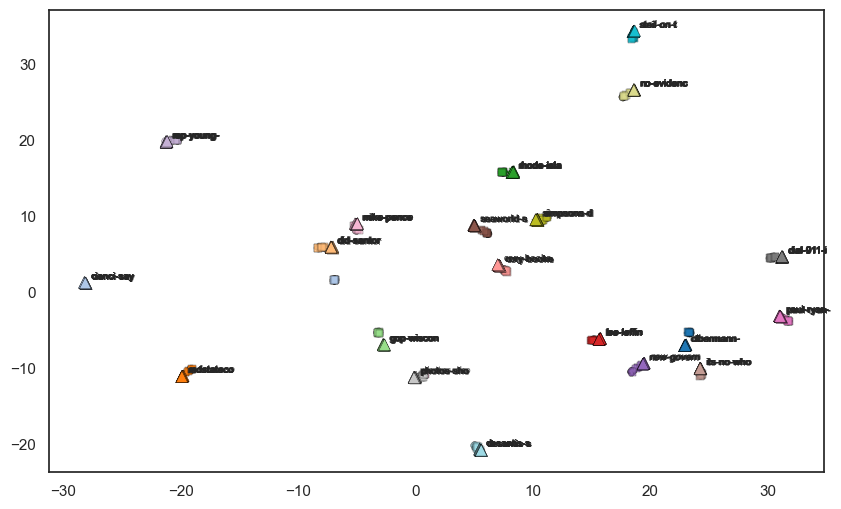

In [13]:
plt.figure(figsize=(10, 6))  # Slightly wider to fit labels
sns.set(style="white")

# Plot each point by round & shape
round_shapes = {
    -1: '^',  # Original
     0: 'o',  # Round 1
     1: 'P',  # Round 2
     2: 's'   # Round 3
}

for r_value, marker in round_shapes.items():
    subset = df[df['round'] == r_value]
    plt.scatter(
        subset['x'], subset['y'],
        s=70 if r_value == -1 else 30,
        marker=marker,
        color=subset['color'],
        edgecolors='black',
        linewidths=0.3,
        alpha=1.0 if r_value == -1 else 0.6,
        zorder=3 if r_value == -1 else 1
    )

    # Add URL annotations only for original points
    if r_value == -1:
        for _, row in subset.iterrows():
            plt.text(
                row['x'] + 0.5,  # small horizontal offset
                row['y'] + 0.5,  # small vertical offset
                row['url'].split('/')[-2][:10],  # short unique ID from URL
                fontsize=7,
                alpha=0.7
            )


### Classification Performance

To evaluate the detectability of misinformation at different stages of generation, we use a fine-tuned RoBERTa-based veracity classifier trained on original PolitiFact claims. The classifier performs 3-way classification: True, Half-True, and False.

We report the predicted label for each generated claim, alongside the ground truth label from our LLM-based annotation pipeline.

In [14]:
metrics_df = pd.read_json(
    os.path.join("script_outputs/visualization/metrics.json")
)
metrics_df

,model,dataset_type,macro_f1,micro_f1,accuracy,precision,recall
0,bert-base-uncased,original,0.64,0.65,0.65,0.64,0.65
1,bert-base-uncased,round_1,0.33,0.33,0.33,0.33,0.33
2,bert-base-uncased,round_2,0.37,0.38,0.38,0.37,0.38
3,bert-base-uncased,round_3,0.36,0.36,0.36,0.36,0.36
4,bert-large-uncased,original,0.66,0.65,0.65,0.67,0.65
5,bert-large-uncased,round_1,0.36,0.36,0.36,0.37,0.36
6,bert-large-uncased,round_2,0.38,0.38,0.38,0.38,0.38
7,bert-large-uncased,round_3,0.35,0.36,0.36,0.37,0.36
8,deberta-v3-base,original,0.70,0.69,0.69,0.70,0.69
9,deberta-v3-base,round_1,0.38,0.39,0.39,0.39,0.39


In [15]:
# Average Cosine Similarities

# Load DataFrame
gen_claim_df = pd.read_json(
    os.path.join("script_outputs/role_playing_misinformation_labelling_output/role_playing_label_outputs.json")
)

# Iterate over the filtered DataFrame safely
round_1_with_original = []
round_2_with_original = []
round_3_with_original = []
round_1_with_round_2 = []
round_2_with_round_3 = []
for url, group in gen_claim_df.groupby(["url"]):
  for idx, row in group.iterrows():
    if row['round'] == 0:
      round_1_with_original.append((row['claim'], row['generated_claims']['Claim']))
    elif row['round'] == 1:
      round_2_with_original.append((row['claim'], row['generated_claims']['Claim']))
      round_1_with_round_2.append((row['previous_claims'][-1]['Claim'], row['generated_claims']['Claim']))
    elif row['round'] == 2:
      round_3_with_original.append((row['claim'], row['generated_claims']['Claim']))
      round_2_with_round_3.append((row['previous_claims'][-1]['Claim'], row['generated_claims']['Claim']))

model = SentenceTransformer("all-MiniLM-L6-v2").to('cuda')

def compute_avg_similarity(pairs):
    scores = []
    for a, b in pairs:
        emb_a = model.encode(a, convert_to_tensor=True)
        emb_b = model.encode(b, convert_to_tensor=True)
        sim = util.cos_sim(emb_a, emb_b).item()
        scores.append(sim)
    return scores

# Compute average similarities
s0 = compute_avg_similarity(round_1_with_original)
s1 = compute_avg_similarity(round_2_with_original)
s2 = compute_avg_similarity(round_3_with_original)
s3 = compute_avg_similarity(round_1_with_round_2)
s4 = compute_avg_similarity(round_2_with_round_3)

# Print results
print("Average SBERT cosine similarities:")
print(f"Original ➔ Round 0: {sum(s0)/len(s0):.4f} (N={len(s0)})")
print(f"Original ➔ Round 1: {sum(s1)/len(s1):.4f} (N={len(s1)})")
print(f"Original ➔ Round 2: {sum(s2)/len(s2):.4f} (N={len(s2)})")
print(f"Round 1 ➔ Round 2: {sum(s3)/len(s3):.4f} (N={len(s3)})")
print(f"Round 2 ➔ Round 3: {sum(s4)/len(s4):.4f} (N={len(s4)})")


d:\Anaconda\envs\cs5242\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Average SBERT cosine similarities:
Original ➔ Round 0: 0.6445 (N=2034)
Original ➔ Round 1: 0.6248 (N=4068)
Original ➔ Round 2: 0.6177 (N=4068)
Round 1 ➔ Round 2: 0.6992 (N=4068)
Round 2 ➔ Round 3: 0.6978 (N=4068)
